In [1]:
import os
from typing import List, Union, Generator, Iterator
from pydantic import BaseModel
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.llms.ollama import Ollama
from llama_index.core import Settings, VectorStoreIndex, SimpleDirectoryReader
import pandas as pd


In [2]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

In [3]:
class RAG:

    class Parameters(BaseModel):
        LLAMAINDEX_OLLAMA_BASE_URL: str
        LLAMAINDEX_MODEL_NAME: str
        LLAMAINDEX_EMBEDDING_MODEL_NAME: str

    def __init__(self):
        self.documents = None
        self.index = None

        self.parameters = self.Parameters(
            LLAMAINDEX_OLLAMA_BASE_URL=os.getenv("LLAMAINDEX_OLLAMA_BASE_URL", "http://localhost:11434"),
            LLAMAINDEX_MODEL_NAME=os.getenv("LLAMAINDEX_MODEL_NAME", "llama3.2:3b"),
            LLAMAINDEX_EMBEDDING_MODEL_NAME=os.getenv("LLAMAINDEX_EMBEDDING_MODEL_NAME", "jina/jina-embeddings-v2-base-en:latest"),
        )

    def on_startup(self):
        Settings.embed_model = OllamaEmbedding(
            model_name=self.parameters.LLAMAINDEX_EMBEDDING_MODEL_NAME,
            base_url=self.parameters.LLAMAINDEX_OLLAMA_BASE_URL,
        )
        Settings.llm = Ollama(
            model=self.parameters.LLAMAINDEX_MODEL_NAME,
            base_url=self.parameters.LLAMAINDEX_OLLAMA_BASE_URL,
        )

        self.documents = SimpleDirectoryReader("test/dataset").load_data()
        self.index = VectorStoreIndex.from_documents(self.documents)

    def on_shutdown(self):
        pass

    def pipe(
        self, user_message: str, model_id: str, messages: List[dict], body: dict, top_k: int = 5
    ) -> Union[str, Generator, Iterator]:
        query_engine = self.index.as_query_engine(streaming=True, top_k=top_k)
        response = query_engine.query(user_message)
        return response.response_gen


def run_query_sync(query: str, top_k: int = 5) -> str:
     rag = RAG()
     rag.on_startup()
     
     user_message = query
     model_id = "llama3.2:3b"
     messages = [{"role": "user", "content": user_message}]
     body = {}
     
     # return top_k vectors (and not the default)
     response_gen = rag.pipe(user_message, model_id, messages, body, top_k=top_k)
     response_text = ''.join(response_gen)

     rag.on_shutdown()
     return response_text

def run_query_sync_old(query: str) -> str:
    rag = RAG()
    rag.on_startup()

    user_message = query
    model_id = "llama3.2:3b"
    messages = [{"role": "user", "content": user_message}]
    body = {}

    response_gen = rag.pipe(user_message, model_id, messages, body)
    response_text = ''.join(response_gen)

    rag.on_shutdown()
    return response_text



In [4]:

def get_billable_answer(long_answer):
    # Split the string by lines
    lines = long_answer.split('\n')
    # Find the line that starts with 'answer:'
    for line in lines:
        if line.startswith("answer:"):
            answer = line.split(":")[1].strip()
            break
        else:
            answer = 'N/A'
    return answer


In [5]:

def get_category_answer(long_answer):
    # Split the string by lines
    lines = long_answer.split('\n')
    # Find the line that starts with 'answer:'
    for line in lines:
        if line.startswith("request_category:"):
            answer = line.split(":")[1].strip()
            break
        else:
            answer = 'N/A'
    return answer

In [6]:
import re

def get_context_answer(long_answer):
    # Use a regular expression to find everything after "context:"
    match = re.search(r"context:\s*(.*)", long_answer, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        return 'N/A'

In [7]:
# Emergency Maintenance (IMBL Scanner Breakdown - Immediate Repair Required)
# Routine Maintenance (Scheduled Maintenance Request for IMBL Scanner)
# Upgrades (Request for Software Upgrade on IMBL Scanner)
# Training (Request for Additional IMBL Scanner Training)
# Replacement Under Warranty (Request for Replacement of Defective IMBL Scanner Part)
# Customization (Request for Customization of IMBL Scanner Settings)
# User-Caused Damage (Repair Request for IMBL Scanner - Accidental Damage)
# New Projects (Request for Installation and Setup of New IMBL Scanner; Request for Remote Troubleshooting - IMBL Scanner Software Issue)
# Performance Reports (Request for Detailed Monthly Performance Report)

In [8]:

if __name__ == "__main__":

    prompt_old1 = 'Classify this question if the request is under the Service Level Agreement (SLA) or not. Return both the relevant passage in the SLA and if the request is covered or not (yes / no)'
    prompt_old = 'Classify this question if the request is under the Service Level Agreement (SLA) or not, do not use internal knowledge, only what is provided in the SLA. Return both the relevant passage in the SLA and if the request is covered or not (Billable / Not Billable)'
    prompt1 = f"""Classify if the following request is covered under the Service Level Agreement (SLA) or not. If it is covered by the SLA then the request is Billable, else the request is Not Billable. Return your reply in the following format:
            answer: [Billable / Not Billable]
            context: [relevant passage from the Service Level Agreement, do not include the customer request here]
            """

    prompt2 = f"""
            Classify the following request among the following request categories:
                - Emergency Maintenance (IMBL Scanner Breakdown - Immediate Repair Required)
                - Routine Maintenance (Scheduled Maintenance Request for IMBL Scanner)
                - Upgrades (Request for Software Upgrade on IMBL Scanner)
                - Training (Request for Additional IMBL Scanner Training)
                - Replacement Under Warranty (Request for Replacement of Defective IMBL Scanner Part)
                - Customization (Request for Customization of IMBL Scanner Settings)
                - User-Caused Damage (Repair Request for IMBL Scanner - Accidental Damage)
                - New Projects (Request for Installation and Setup of New IMBL Scanner; Request for Remote Troubleshooting - IMBL Scanner Software Issue)
                - Performance Reports (Request for Detailed Monthly Performance Report)
                - Other

            Then check if the following request is covered under the Service Level Agreement (SLA) or not. Return the relevant passages from the SLA under "context" below.
            Then decide if the request is covered by the SLA, in that case the request is Billable, else the request is Not Billable.
            
            Return your reply in the following format:
            request_category: [one of the request category above] 
            context: [relevant passage from the Service Level Agreement, do not include the customer request here]
            answer: [Billable / Not Billable]
            """


    prompt = f"""
            Classify the following request among the following request categories:
                - Emergency Maintenance (IMBL Scanner Breakdown - Immediate Repair Required)
                - Routine Maintenance (Scheduled Maintenance Request for IMBL Scanner)
                - Upgrades (Request for Software Upgrade on IMBL Scanner)
                - Training (Request for Additional IMBL Scanner Training)
                - Replacement Under Warranty (Request for Replacement of Defective IMBL Scanner Part)
                - Customization (Request for Customization of IMBL Scanner Settings)
                - User-Caused Damage (Repair Request for IMBL Scanner - Accidental Damage)
                - New Projects (Request for Installation and Setup of New IMBL Scanner; Request for Remote Troubleshooting - IMBL Scanner Software Issue)
                - Performance Reports (Request for Detailed Monthly Performance Report)
                - Other

            Then check if the following request is covered under the Service Level Agreement (SLA) or not. Return the relevant passages from the SLA under "context" below.
            Then decide if the request is covered by the SLA, in that case the request is Billable, else the request is Not Billable.
            
            Return your reply in the following JSON format:
            request_category: [one of the request category above] 
            context: [relevant passage from the Service Level Agreement, do not include the customer request here]
            answer: [Billable / Not Billable]
            """
    
    df_questions = pd.read_csv('test/qa/QA_billability.csv')
    df_questions['predicted_answer'] = None
    df_questions['predicted_answer'] = None



    for case_nb in range(0,df_questions.shape[0]):
        question = df_questions['question'][case_nb]
        query = prompt + question
        print("\n================================")
        print(f'case_nb', case_nb)     
        print(f'question:', question)
        #print(query)
        response = run_query_sync(query, top_k=5)
        print("\nResponse:")

        pred_category = get_category_answer(response)
        df_questions.loc[case_nb, 'predicted_category'] = pred_category
        print(f'predicted_category:', pred_category)

        pred_context = get_context_answer(response)
        df_questions.loc[case_nb, 'predicted_context'] = pred_context
        print(f'predicted_context:', pred_context)

        pred_billable = get_billable_answer(response)
        df_questions.loc[case_nb, 'predicted_answer'] = pred_billable
        print(f'predicted_billable:', pred_billable)

        print(f'expected_answer:', df_questions['expected_answer'][case_nb])
        print(f'expected_context:', df_questions['context'][case_nb])

        if pred_billable == df_questions['expected_answer'][case_nb]:
            print('Prediction correct')
        else:
            print('PREDICTION WRONG !!!')
        print("--------------------------------")


case_nb 0
question: Subject: IMBL Scanner Breakdown - Immediate Repair Required Dear Support Team, We are experiencing a sudden breakdown of our IMBL Scanner, rendering it non-operational. We request immediate assistance for emergency repairs to restore functionality as soon as possible. Thank you for your prompt attention to this matter. Best regards, [Customer Name]

Response:
predicted_category: Emergency Maintenance (IMBL Scanner Breakdown - Immediate Repair Required)
predicted_context: - 19.2. Response Times
    - Emergency Maintenance: For critical issues that render the Equipment non-operational, the Service Provider shall respond within 2 hours of notification and commence repairs within 4 hours.
answer: Billable
predicted_billable: Billable
expected_answer: Billable
expected_context: Emergency maintenance is typically covered but billed separately as per response time clauses
Prediction correct
--------------------------------

case_nb 1
question: Subject: Scheduled Maintenan

In [ ]:
request_category: [one of the request category above] 
            context: [relevant passage from the Service Level Agreement, do not include the customer request here]
            answer: [Billable / Not Billable]
            """
    
    df_questions = pd.read_csv('test/qa/QA_billability.csv')
    df_questions['predicted_answer'] = None
    df_questions['predicted_answer'] = None



    for case_nb in range(0,df_questions.shape[0]):
        question = df_questions['question'][case_nb]
        query = prompt + question
        print("\n================================")
        print(f'case_nb', case_nb)     
        print(f'question:', question)
        #print(query)
        response = run_query_sync(query, top_k=5)
        print("\nResponse:")

        pred_category = get_category_answer(response)
        df_questions.loc[case_nb, 'predicted_category'] = pred_category
        print(f'predicted_category:', pred_category)

        pred_context = get_context_answer(response)
        df_questions.loc[case_nb, 'predicted_context'] = pred_context
        print(f'predicted_context:', pred_context)

        pred_billable = get_billable_answer(response)
        df_questions.loc[case_nb, 'predicted_answer'] = pred_billable
        print(f'predicted_billable:', pred_billable)

        print(f'expected_answer:', df_questions['expected_answer'][case_nb])
        print(f'expected_context:', df_questions['context'][case_nb])

        if pred_billable == df_questions['expected_answer'][case_nb]:
            print('Prediction correct')
        else:
            print('PREDICTION WRONG !!!')
        print("--------------------------------")

In [9]:
df_questions

,question,expected_answer,context,predicted_answer,predicted_category,predicted_context
0,Subject: IMBL Scanner Breakdown - Immediate Re...,Billable,Emergency maintenance is typically covered but...,Billable,Emergency Maintenance (IMBL Scanner Breakdown ...,- 19.2. Response Times\n - Emergency Mainte...
1,Subject: Scheduled Maintenance Request for IMB...,Not Billable,Routine maintenance is usually included in the...,Not Billable,Routine Maintenance,19.2. Response Times - For non-critical issues...
2,Subject: Request for Software Upgrade on IMBL ...,Billable,Routine maintenance is usually included in the...,Not Billable,Upgrades,19.2. Response Times - Routine Maintenance Req...
3,Subject: Request for Additional IMBL Scanner T...,Billable,Upgrades are generally outside the regular mai...,Not Billable,Training,19.4. Performance Standards - Qualified Person...
4,Subject: Request for Replacement of Defective ...,Not Billable,Training services are not part of regular main...,Not Billable,Replacement Under Warranty,19.7. Exclusions - Scheduled Maintenance: Down...
5,Subject: Request for Customization of IMBL Sca...,Billable,Replacement under warranty is typically covere...,Not Billable,Customization,19.4. Performance Standards\n- Quality of Serv...
6,Subject: Request for Detailed Monthly Performa...,Billable,Customization generally falls outside standard...,Billable,Performance Reports,19.5. Reporting - Maintenance Reports: The Ser...
7,Subject: Repair Request for IMBL Scanner - Acc...,Billable,If detailed reports are part of the agreed SLA...,Not Billable,User-Caused Damage,19.1. Availability\n- Uptime Guarantee: The Se...
8,Subject: Request for Installation and Setup of...,Billable,User-caused damage is typically not covered un...,Not Billable,New Projects,The Service Provider agrees to meet the perfor...
9,Subject: Request for Remote Troubleshooting - ...,Not Billable,This would be considered a new project setup a...,Billable,New Projects,19.2. Response Times\n - Emergency Maintena...


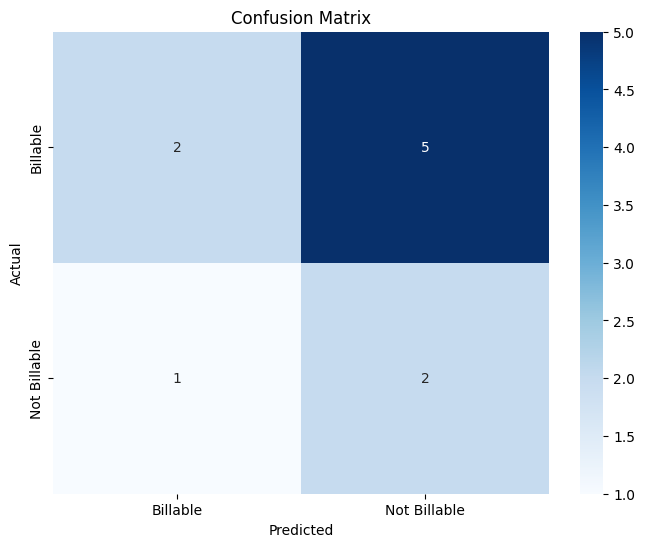

In [10]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Create confusion matrix
conf_matrix = confusion_matrix(df_questions['expected_answer'], df_questions['predicted_answer'], labels=['Billable', 'Not Billable'])

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Billable', 'Not Billable'], columns=['Billable', 'Not Billable'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [11]:
from sklearn.metrics import accuracy_score
# Calculate accuracy
accuracy = accuracy_score(df_questions['expected_answer'], df_questions['predicted_answer'])
print(f"Accuracy: {accuracy}")

Accuracy: 0.4


In [12]:
display_all(df_questions)

,question,expected_answer,context,predicted_answer,predicted_category,predicted_context
0,Subject: IMBL Scanner Breakdown - Immediate Re...,Billable,Emergency maintenance is typically covered but...,Billable,Emergency Maintenance (IMBL Scanner Breakdown ...,- 19.2. Response Times\n - Emergency Mainte...
1,Subject: Scheduled Maintenance Request for IMB...,Not Billable,Routine maintenance is usually included in the...,Not Billable,Routine Maintenance,19.2. Response Times - For non-critical issues...
2,Subject: Request for Software Upgrade on IMBL ...,Billable,Routine maintenance is usually included in the...,Not Billable,Upgrades,19.2. Response Times - Routine Maintenance Req...
3,Subject: Request for Additional IMBL Scanner T...,Billable,Upgrades are generally outside the regular mai...,Not Billable,Training,19.4. Performance Standards - Qualified Person...
4,Subject: Request for Replacement of Defective ...,Not Billable,Training services are not part of regular main...,Not Billable,Replacement Under Warranty,19.7. Exclusions - Scheduled Maintenance: Down...
5,Subject: Request for Customization of IMBL Sca...,Billable,Replacement under warranty is typically covere...,Not Billable,Customization,19.4. Performance Standards\n- Quality of Serv...
6,Subject: Request for Detailed Monthly Performa...,Billable,Customization generally falls outside standard...,Billable,Performance Reports,19.5. Reporting - Maintenance Reports: The Ser...
7,Subject: Repair Request for IMBL Scanner - Acc...,Billable,If detailed reports are part of the agreed SLA...,Not Billable,User-Caused Damage,19.1. Availability\n- Uptime Guarantee: The Se...
8,Subject: Request for Installation and Setup of...,Billable,User-caused damage is typically not covered un...,Not Billable,New Projects,The Service Provider agrees to meet the perfor...
9,Subject: Request for Remote Troubleshooting - ...,Not Billable,This would be considered a new project setup a...,Billable,New Projects,19.2. Response Times\n - Emergency Maintena...
